# Downloading Packages

In [ ]:
!python -m pip install pyyaml
import sys, os, distutils.core
!pip install torch
# Detectron 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install torchvision
!pip install opencv-python

# Import Downloaded packages

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/usr/bin/sh: 1: nvcc: not found
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [3]:
# Andre pakker

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [4]:
import os
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import convert_to_coco_json
import shutil
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Import images from GitHub

In [5]:
from getpass import getpass
import subprocess

# Get GitHub token
token = getpass("Enter your GitHub token: ")

# Define repository URL
repo_url = f"https://{token}@github.com/casperbak1/Dataprojekt.git"

# Kloner main branch, og kun seneste commit (depth 1)
subprocess.run(["git", "clone", "--branch", "main", "--depth", "1", repo_url])

repo_path = "Dataprojekt"
if os.path.exists(repo_path):  # Hvis der findes en GitHub sti "Dataprojekt"
    subprocess.run(["git", "sparse-checkout", "init", "--cone"], cwd=repo_path) # Så klon mappen "Data/Clean Data/Overbite Data"
    subprocess.run(["git", "sparse-checkout", "set", "Data/Clean Data/Overbite Data"], cwd=repo_path)

print("Repository cloned with only the 'Overbite Data' folder.")

Enter your GitHub token:  ········


Repository cloned with only the 'Overbite Data' folder.


# Initialise the training data

In [36]:
# Load the annotations from the CSV file
ANNOTATIONS_FILE = "Dataprojekt/Data/Clean Data/Overbite Data/Updated_Labels.csv"
annotations_df = pd.read_csv(ANNOTATIONS_FILE)

# Sti til dataen
DATASET_PATH = "Dataprojekt/Data/Clean Data/Overbite Data/Annotated Data Pairs"

def my_dataset_function():
    dataset_dicts = []

    grouped_annotations = annotations_df.groupby("Filename")

    for idx, filename in enumerate(os.listdir(DATASET_PATH)):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            record = {}
            file_path = os.path.join(DATASET_PATH, filename)

            # Read image dimensions
            image = cv2.imread(file_path)
            height, width = image.shape[:2]

            record["file_name"] = file_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            record["annotations"] = []

            if filename in grouped_annotations.groups:
                keypoints_list = []
                bboxes = []

                for _, row in grouped_annotations.get_group(filename).iterrows():
                    x, y = row["X"], row["Y"]
                    
                    # Add keypoint
                    keypoints_list.extend([x, y, 2])  # visible

                    # Create a bounding box around the keypoint
                    box_x = max(x - 50, 0)
                    box_y = max(y, 0)
                    box_w = min(100, width - box_x)
                    box_h = min(100, height - box_y)

                    bboxes.append([box_x, box_y, box_w, box_h])

                # One annotation per keypoint
                for i in range(len(keypoints_list) // 3):
                    x = keypoints_list[i * 3]
                    y = keypoints_list[i * 3 + 1]
                    annotation = {
                        "bbox": bboxes[i],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "category_id": 0,
                        "keypoints": keypoints_list[i*3:i*3+3],
                        "num_keypoints": 1
                    }
                    record["annotations"].append(annotation)

            dataset_dicts.append(record)

    return dataset_dicts

# Register the dataset
DatasetCatalog.register("Overbite_Data", my_dataset_function)
MetadataCatalog.get("Overbite_Data").set(
    thing_classes=["object"],  # Modify for actual class names (Mangler godt navn)
    keypoint_names=["keypoint"],  # Name of keypoints (Mangler endnu bedre navn)
    keypoint_flip_map=[]  # Add keypoint flip pairs if needed (Nope)
)

# Test if it works
dataset_dicts = DatasetCatalog.get("Overbite_Data")
print(f"Loaded {len(dataset_dicts)} images with keypoints.")

Loaded 1585 images with keypoints.


# Visualise data

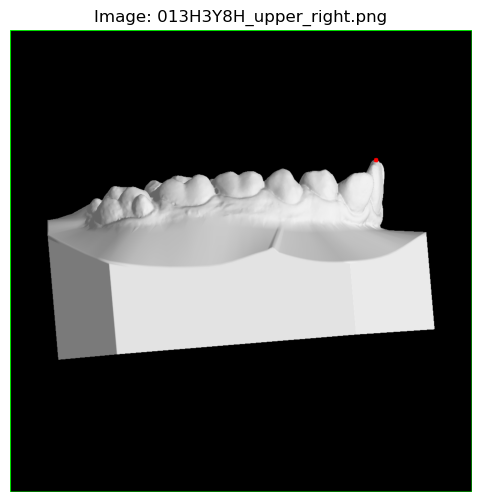

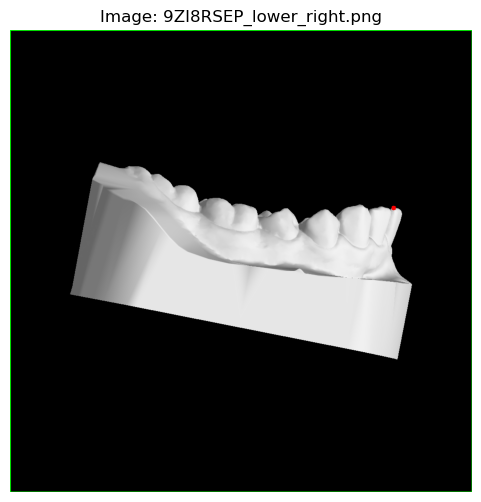

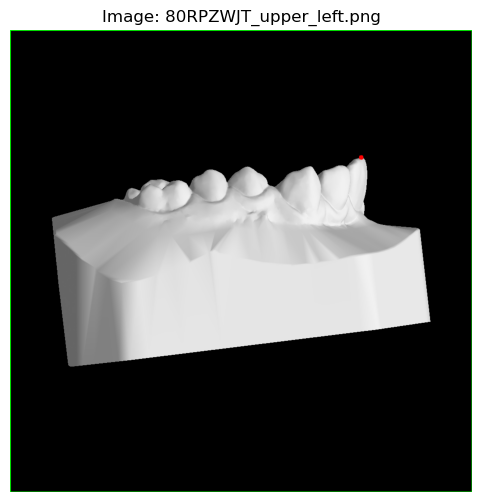

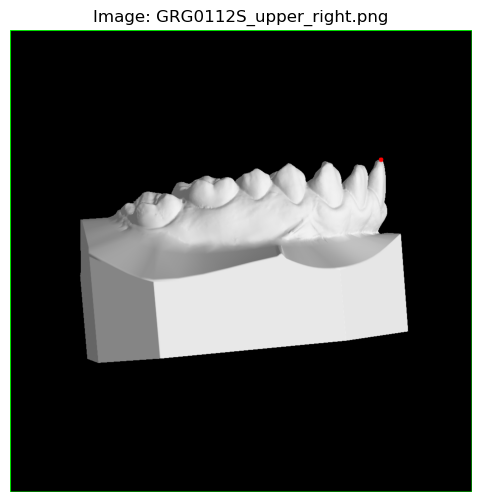

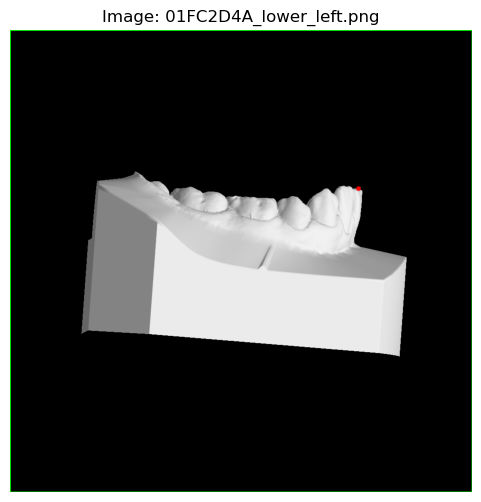

In [46]:
import cv2
import random
import matplotlib.pyplot as plt

# Load dataset dicts
dataset_dicts = my_dataset_function()

# Pick 3–5 random samples
sampled = random.sample(dataset_dicts, min(5, len(dataset_dicts)))

for d in sampled:
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for matplotlib display

    for anno in d["annotations"]:
        # Draw bbox
        x, y, w, h = map(int, anno["bbox"])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw keypoint
        kp_x, kp_y = int(anno["keypoints"][0]), int(anno["keypoints"][1])
        cv2.circle(img, (kp_x, kp_y), 5, (255, 0, 0), -1)  # Red dot

    # Show with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image: {os.path.basename(d['file_name'])}")
    plt.axis("off")
    plt.show()


# Delete if needed

In [49]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name = "Overbite_Validation"

# Unregister dataset if already registered
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)
    print(f"🗑️ Unregistered dataset: {dataset_name}")

🗑️ Unregistered dataset: Overbite_Validation


# Initialise the validation data

In [ ]:
# Funktion til at hente verifikationsdata
def my_validation_function():
    dataset_dicts = []
    DATASET_PATH = "Dataprojekt/Data/Clean Data/Overbite Data/Annotated Verication data"

    grouped_annotations = annotations_df.groupby("Filename")

    for idx, filename in enumerate(os.listdir(DATASET_PATH)):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            record = {}
            file_path = os.path.join(DATASET_PATH, filename)
            image = cv2.imread(file_path)
            height, width = image.shape[:2]

            record["file_name"] = file_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            record["annotations"] = []

            if filename in grouped_annotations.groups:
                keypoints_list = []
                bboxes = []

                for _, row in grouped_annotations.get_group(filename).iterrows():
                    x, y = row["X"], row["Y"]
                    keypoints_list.extend([x, y, 2])

                    # Create a bounding box around the keypoint
                    box_x = max(x - 50, 0)
                    box_y = max(y, 0)
                    box_w = min(100, width - box_x)
                    box_h = min(100, height - box_y)

                    bboxes.append([box_x, box_y, box_w, box_h])

                # One keypoint = one annotation
                for i in range(len(keypoints_list) // 3):
                    annotation = {
                        "bbox": bboxes[i],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "category_id": 0,
                        "keypoints": keypoints_list[i*3:i*3+3],
                        "num_keypoints": 1
                    }
                    record["annotations"].append(annotation)

            dataset_dicts.append(record)

    return dataset_dicts

# Registrér valideringsdatasæt
DatasetCatalog.register("Overbite_Validation", my_validation_function)
MetadataCatalog.get("Overbite_Validation").set(
    thing_classes=["object"],
    keypoint_names=["keypoint"],
    keypoint_flip_map=[]
)

namespace(name='Overbite_Validation',
          thing_classes=['object'],
          keypoint_names=['keypoint'],
          keypoint_flip_map=[])

# Train the model

# Setup 2

In [ ]:
# 🧼 Træls Warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import (
    build_detection_test_loader,
    build_detection_train_loader,
    detection_utils as utils,
    transforms as T,
)
from detectron2.structures import BoxMode
from detectron2.data.datasets import convert_to_coco_json

# ----------------------------------------
# ✅ Custom Augmentation Mapper (Fixed)
# ----------------------------------------
def custom_mapper(dataset_dict):
    dataset_dict = dataset_dict.copy()
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    aug = [
        T.ResizeShortestEdge(short_edge_length=(640, 720, 768), max_size=1024, sample_style='choice'),
        # This was in your original version and might be critical
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(aug, image)
    image_tensor = torch.as_tensor(image.transpose(2, 0, 1).copy(), dtype=torch.float32)
    dataset_dict["image"] = image_tensor

    annos = [utils.transform_instance_annotations(
        obj, transforms, image.shape[:2],
        keypoint_hflip_indices=[0]  # even though it's sketchy, the original had it
    ) for obj in dataset_dict["annotations"]]

    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = instances
    return dataset_dict

# ----------------------------------------
# ✅ Custom Trainer
# ----------------------------------------
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# ----------------------------------------
# ✅ Config Setup
# ----------------------------------------
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("Overbite_Data",)
cfg.DATASETS.TEST = ("Overbite_Validation",)

cfg.DATALOADER.NUM_WORKERS = 8
cfg.SOLVER.IMS_PER_BATCH = 16  # safer batch size
cfg.SOLVER.BASE_LR = 0.002     # fine-tuning friendly
cfg.SOLVER.MAX_ITER = 25000
cfg.SOLVER.STEPS = (2000, 6000)
cfg.SOLVER.GAMMA = 0.1

# Warmup & Gradient Clipping
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0

# AMP on (now that training is stable)
cfg.SOLVER.AMP.ENABLED = True

# Model Head
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 1

# Tight OKS threshold for mm-level precision
cfg.TEST.KEYPOINT_OKS_SIGMAS = [0.01]
cfg.TEST.EVAL_PERIOD = 1000

cfg.OUTPUT_DIR = "./output3/Overbite_Model"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# ----------------------------------------
# ✅ COCO Conversion (for external validation)
# ----------------------------------------
coco_annotation_path = os.path.join(cfg.OUTPUT_DIR, "Overbite_Validation_coco_format.json")
convert_to_coco_json("Overbite_Validation", coco_annotation_path)
print(f"✅ Validation set converted to COCO format: {coco_annotation_path}")

# ----------------------------------------
# ✅ Train!
# ----------------------------------------
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# ----------------------------------------
# ✅ Evaluate
# ----------------------------------------
val_loader = build_detection_test_loader(cfg, "Overbite_Validation")
inference_on_dataset(
    trainer.model,
    val_loader,
    COCOEvaluator("Overbite_Validation", cfg, False, output_dir=cfg.OUTPUT_DIR)
)

print("✅ Training and validation completed successfully!")


WARNING [04/22 20:16:30 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output4/Overbite_Model/Overbite_Validation_coco_format.json'. You need to clear the cache file if your dataset has been modified.
✅ Validation set converted to COCO format: ./output4/Overbite_Model/Overbite_Validation_coco_format.json
[04/22 20:16:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 2

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 1, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (1,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[04/22 20:16:44 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.12/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/opt/conda/lib/python3.12/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/opt/conda/lib/python3.12/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. P

[04/22 20:16:58 d2.utils.events]:  eta: 4:43:31  iter: 19  total_loss: 8.604  loss_cls: 0.1842  loss_box_reg: 0.1539  loss_keypoint: 8.005  loss_rpn_cls: 0.2208  loss_rpn_loc: 0.04314    time: 0.6868  last_time: 0.6692  data_time: 0.1549  last_data_time: 0.1276   lr: 3.9962e-05  max_mem: 63726M
[04/22 20:17:12 d2.utils.events]:  eta: 4:44:50  iter: 39  total_loss: 7.998  loss_cls: 0.06383  loss_box_reg: 0.09985  loss_keypoint: 7.782  loss_rpn_cls: 0.03514  loss_rpn_loc: 0.02608    time: 0.6871  last_time: 0.6871  data_time: 0.1398  last_data_time: 0.1314   lr: 7.9922e-05  max_mem: 63726M
[04/22 20:17:26 d2.utils.events]:  eta: 4:44:36  iter: 59  total_loss: 7.02  loss_cls: 0.01661  loss_box_reg: 0.02029  loss_keypoint: 6.958  loss_rpn_cls: 0.004165  loss_rpn_loc: 0.02175    time: 0.6861  last_time: 0.6694  data_time: 0.1377  last_data_time: 0.1288   lr: 0.00011988  max_mem: 63726M
[04/22 20:17:39 d2.utils.events]:  eta: 4:44:17  iter: 79  total_loss: 5.19  loss_cls: 0.01192  loss_box_r

KeyboardInterrupt: 